In [22]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
from scipy.linalg import hankel

import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [23]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [24]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [25]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [26]:
IPython.display.Audio('ClocheB.WAV')

In [27]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

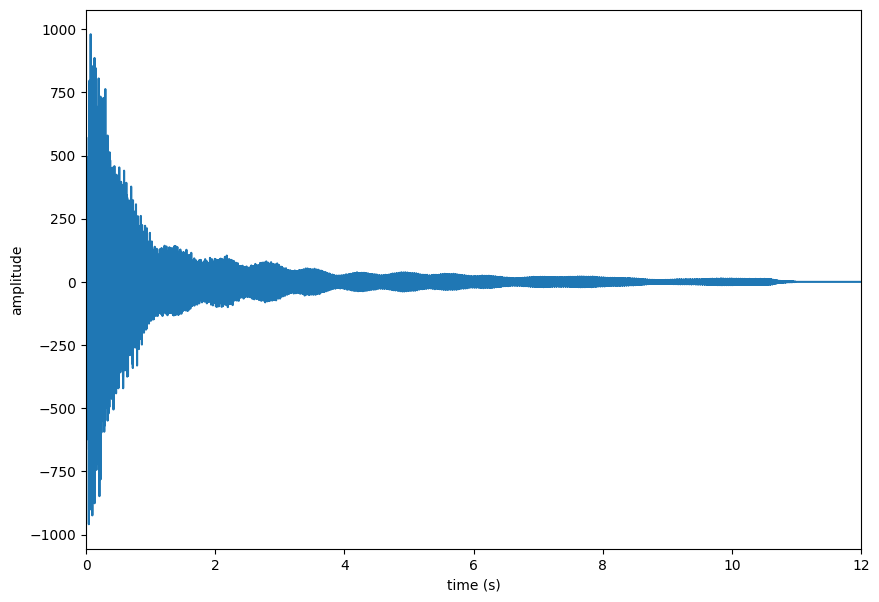

In [28]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [29]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# Part 2

In [30]:
N = 63

f_0 = 1/4
f_signal = np.array([f_0, f_0 + 1/N], dtype=complex)
a = np.array([1, 10])
delta = np.array([0, -0.05])
phi = np.random.uniform(-np.pi, np.pi, size=2)


x_signal = Synthesis(N, delta, f_signal, a, phi)

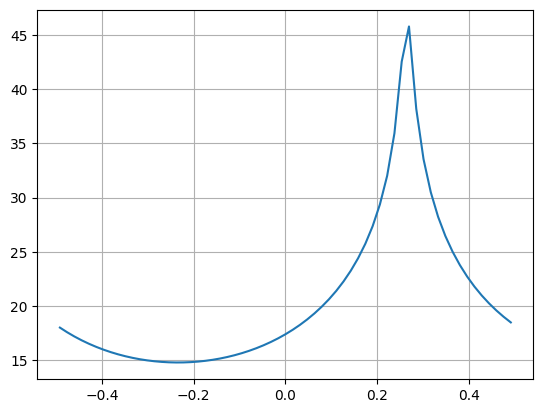

In [31]:
FFT_x = np.fft.fft(x_signal, n=N)
FFT_x = np.fft.fftshift(FFT_x)
f = np.fft.fftfreq(N)
f = np.fft.fftshift(f)

plt.plot(f, 10*np.log10(np.abs(FFT_x)**2))
plt.grid()
plt.show()

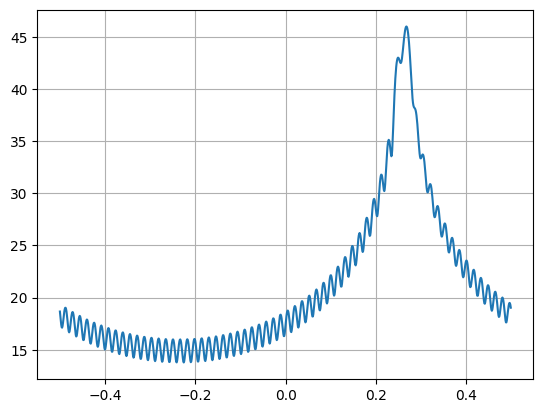

In [32]:
FFT_x = np.fft.fft(x_signal, n=1024)
FFT_x = np.fft.fftshift(FFT_x)
f = np.fft.fftfreq(1024)
f = np.fft.fftshift(f)

plt.plot(f, 10*np.log10(np.abs(FFT_x)**2))
plt.grid()
plt.show()

In [33]:
def empirical_covaraince(signal, n):
    N = len(signal)
    l = N - n + 1
    X = hankel(signal[0: n], signal[n-1: N])
    return (1/l) * (X @ X.conj().T)

In [34]:
def Esprit(x, n, K):

    R_xx = empirical_covaraince(x, n)
    U, S, V = np.linalg.svd(R_xx)
    W = U[:, :K]
    W_down = W[: -1]
    W_up = W[1 :]
    phi_Matrix = np.linalg.pinv(W_down) @ W_up
    eingen_values, _ = np.linalg.eig(phi_Matrix)
    
    delta_empirical = np.log(np.abs(eingen_values))
    f_empirical = (1/(2*np.pi)) * np.angle(eingen_values)

    return np.flip(delta_empirical), np.flip(f_empirical)


def LeastSquares(x, delta, f):

    t = np.arange(x.shape[0]).reshape(-1, 1)
    exponent = delta + 2j * np.pi * f
    ln_V_N = t @ exponent.reshape(1, -1)
    
    V_n = np.exp(ln_V_N)
    V_n_inverse = np.linalg.pinv(V_n)

    alpha = V_n_inverse @ x
    a_empirical = np.abs(alpha)
    phi_empirical = np.angle(alpha) 

    return np.flip(a_empirical), np.flip(phi_empirical)


delta_empirical, f_empirical = Esprit(x_signal, 32, 2)
a_empirical, phi_empirical = LeastSquares(x_signal, delta_empirical, f_empirical)

print(f"delta are: {delta_empirical}, f are: {f_empirical}, a are: {a_empirical} and phis are: {phi_empirical}")
    

delta are: [ 4.4408921e-16 -5.0000000e-02], f are: [0.25       0.26587302], a are: [10.  1.] and phis are: [-2.9225386  -2.59488181]


(32, 30)


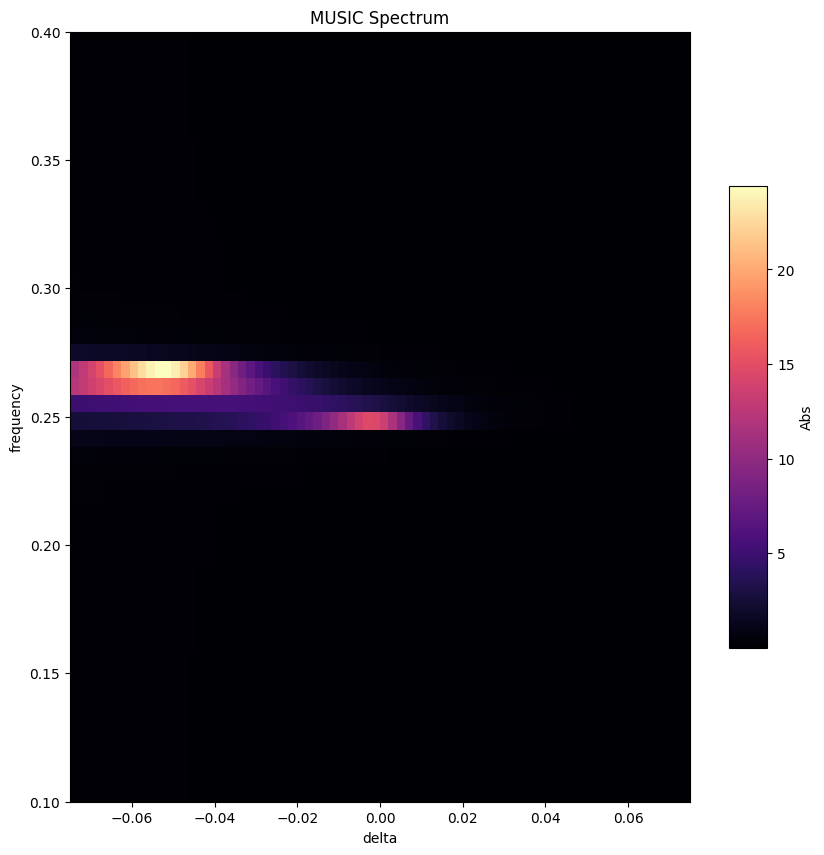

In [35]:
def Music(x, n, K):
    
    R_xx = empirical_covaraince(x, n)
    
    U, S, V = np.linalg.svd(R_xx)
    W_T = U[:, K:]
    print(W_T.shape)
    
    f_vals = np.linspace(0, 1, 150)
    delta_vals = np.linspace(-0.1, 0.1, 100)
    f_grid, delta_grid = np.meshgrid(f_vals, delta_vals)
    
    result = np.zeros_like(f_grid)

    for i in range(f_grid.shape[0]):
        for j in range(f_grid.shape[1]):
            f = f_grid[i, j]
            delta = delta_grid[i, j]
            v = np.array([np.exp((delta + 2j * np.pi * f) * k) for k in range(n)])
            result[i, j] = 1 / (np.linalg.norm(W_T.conj().T @ v)**2)

    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    surf = ax.pcolormesh(delta_grid, f_grid, result, cmap='magma')
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, label="Abs")
    ax.set_xlabel('delta')
    ax.set_ylabel('frequency')
    ax.set_ylim(0.1, 0.4)
    ax.set_xlim(-0.075, 0.075)
    plt.title('MUSIC Spectrum')
    plt.show()

Music(x_signal, n=32, K=2)

In [36]:
T, data_a, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs_A = int(wavefile.getframerate())
bell_a = np.array(data_a).flatten()
num_samples_A = int(wavefile.getnframes())

T, data_b, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')
Fs_B = int(wavefile.getframerate())
bell_b = np.array(data_b).flatten()
num_samples_B = int(wavefile.getnframes())

In [37]:
K = 54
n = 512
l = 1024
N = n + l - 1

bell_A = bell_a[10_000: 10_000 + N]
bell_B = bell_b[10_000: 10_000 + N]

delta_bell_A, f_bell_A = Esprit(bell_A, n, K)
a_empirical_A, phi_empirical_A = LeastSquares(bell_A, delta_bell_A, f_bell_A)

delta_bell_B, f_bell_B, = Esprit(bell_B, n, K) 
a_empirical_B, phi_empirical_B = LeastSquares(bell_B, delta_bell_B, f_bell_B)

In [38]:
synthesised_signal_A = Synthesis(4 * Fs_A, delta_bell_A, f_bell_A, a_empirical_A, phi_empirical_A)
synthesised_signal_B = Synthesis(4 * Fs_B, delta_bell_B, f_bell_B, a_empirical_B, phi_empirical_B)

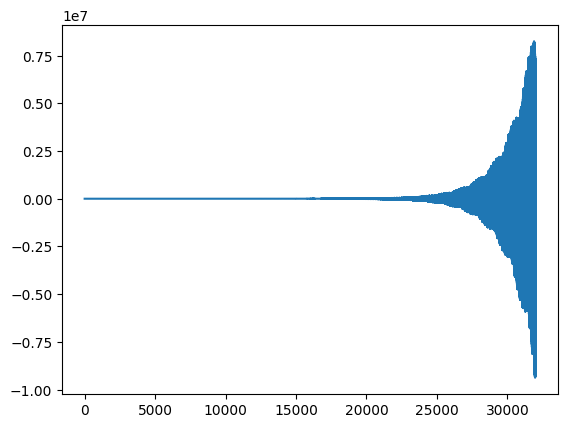

In [39]:
plt.plot(np.real(synthesised_signal_A))
plt.show()

In [40]:
write('bell_A.wav', Fs_A, np.array(np.real(synthesised_signal_A), dtype=np.int16))
write('bell_B.wav', Fs_B, np.array(np.real(synthesised_signal_B), dtype=np.int16))

In [41]:
IPython.display.Audio("bell_A.wav")